# Siamese Neural Networks for One-shot Image Recognition

In [26]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt

from torch.utils.data.dataloader import DataLoader
from torchvision import transforms

%matplotlib inline

Implementation of paper **Siamese Neural Networks for One-shot Image Recognition** by Gregory Koch, Richard Zemel and Ruslan Salakhutdinov. The paper can be obtained from: https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf

## Load datasets

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.  
Source: https://github.com/zalandoresearch/fashion-mnist

Images needs to be transformed during loading time. 

In [2]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [3]:
train_dataset = torchvision.datasets.FashionMNIST('datasets/fashionmnist', 
                                                  train=True,
                                                  transform=transform,
                                                  download=True)
test_dataset = torchvision.datasets.FashionMNIST('datasets/fashionmnist', 
                                                  train=False,
                                                  transform=transform,
                                                  download=True)

Next step is creating loader for fashion mnist datasets.

In [19]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [20]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

In [21]:
images.shape, labels.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Plot example images.

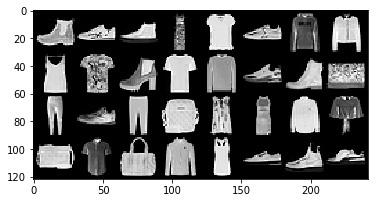

In [22]:
def imshow(x):
    x = x.numpy()
    x = np.transpose(x, (1, 2, 0))
    plt.imshow(x)

imshow(torchvision.utils.make_grid(images))

## Convolutional architecture for siamese neural network

Select device. I am using GPU.

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
assert device.type == 'cuda'

print(torch.cuda.get_device_name(0))

GeForce GTX 1060


Network consists of four convolutional 2-dimensional layers and one fully connected layer.  

In [24]:
class Siamese(nn.Module):
    def __init__(self):
        super(Siamese, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, 10),
            nn.ReLU(),
            nn.MaxPool2d((2, 2))
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 7),
            nn.ReLU(),
            nn.MaxPool2d((2, 2))
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 128, 4),
            nn.ReLU(),
            nn.MaxPool2d((2, 2))
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, 4),
            nn.ReLU()
        )
        
        self.fc1 = nn.Sequential(
            nn.Linear(4096, 1 ),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.fc1(x)
        
        return x
    
net = Siamese().to(device)
net

Siamese(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(10, 10), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
  )
  (fc1): Sequential(
    (0): Linear(in_features=4096, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

## Training

Setting loss function and optimizer.

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.00001, weight_decay=0.001)

In [29]:
net.train()
n_epoch = 30
loss_history = list()

for epoch in range(n_epoch):
    running_loss = 0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')        

RuntimeError: sizes must be non-negative